In [513]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
from IPython.display import display, clear_output
import os, sys
os.getcwd()

'/Users/panxingnan/QuickTourForDeepLearning/Example/Logistic Regression'

# 一、配置学习环境  

![配置学习环境](./sources/0.procedure.png) 

## 1. 界定任务  

应用领域：结构化数据  

结果类型：2分类  

![界定任务](./sources/1.task.png)  

In [514]:
path_data = './data/new_database_results.xls'
data = pd.read_excel(path_data, sheet_name='results')
data.iloc[0:3, 1:].round(1)

,Kerne_A,Cyto_A,K/C,Kerne_Ycol,Cyto_Ycol,KerneShort,KerneLong,KerneElong,KerneRund,CytoShort,...,KernePeri,CytoPeri,KernePos,KerneMax,KerneMin,CytoMax,CytoMin,Class,ClassName1,ClassName2
0,803.5,27804.1,0.0,85.9,192.5,29.8,34.8,0.9,0.8,181.6,...,101.4,673.5,0.2,44,37,649,655,1,normal_superficiel,normal
1,610.1,18067.9,0.0,81.5,153.4,25.3,30.8,0.8,0.8,171.1,...,85.2,597.0,0.0,36,26,502,504,1,normal_superficiel,normal
2,990.4,79029.9,0.0,77.8,118.0,33.6,38.3,0.9,0.9,290.3,...,111.8,1059.1,0.1,53,37,2267,2500,1,normal_superficiel,normal


Kerne_A：核面积  
Cyto_A：浆面积  
K/C：核浆比  
Kerne_Ycol：核颜色  
Cyto_Ycol：浆颜色  
KerneShort：核短轴  
KerneLong：核长轴  
KerneRund：核圆度  
CytoShort：浆短轴  
CytoLong：浆长轴  
CytoRund：浆圆度  

## 2. 准备数据

数据标注：强监督

![准备数据](./sources/2.data1.png)  
  
  
数据集：只生成训练集和测试集  

![准备数据](./sources/2.data2.png)  

### 2-1. 采集数据

### 2-2. 检查、清洗数据  

- 唯一性  

- 一致性  

- 完整性  

- 准确性  

### 2-3. 预处理数据  

- 去掉不必要的列  

- 生成分类标签  

- 将特征归一化  


In [515]:
# 去掉不必要的列
df = data.drop(['ID', 'ClassName1', 'ClassName2'], axis=1)

In [516]:
# 生成分类标签
bins = [0, 3, 7]
df['label'] = pd.cut(df['Class'], bins=bins, labels=[0, 1])
print('2分类标签')
df[['Class', 'label']].drop_duplicates()

2分类标签


,Class,label
0,1,0
74,2,0
144,3,0
242,4,1
424,5,1
570,6,1
767,7,1


In [517]:
# 将特征归一化
label = df['label']
feature = df.drop(['Class', 'label'], axis=1)

print('归一化前数值')
feature.head(3)

归一化前数值


,Kerne_A,Cyto_A,K/C,Kerne_Ycol,Cyto_Ycol,KerneShort,KerneLong,KerneElong,KerneRund,CytoShort,CytoLong,CytoElong,CytoRund,KernePeri,CytoPeri,KernePos,KerneMax,KerneMin,CytoMax,CytoMin
0,803.500,27804.125,0.028087,85.866083,192.524631,29.832191,34.828150,0.856554,0.843403,181.574886,242.043385,0.750175,0.604273,101.375,673.500,0.230067,44,37,649,655
1,610.125,18067.875,0.032665,81.531353,153.439838,25.319871,30.805844,0.821918,0.818583,171.108766,197.570241,0.866065,0.589351,85.250,597.000,0.043701,36,26,502,504
2,990.375,79029.875,0.012377,77.843655,118.001177,33.552901,38.327536,0.875425,0.858397,290.250246,355.803316,0.815760,0.794843,111.750,1059.125,0.141150,53,37,2267,2500


In [518]:
feature = (feature - feature.mean())/feature.std()
print('归一化后数值')
feature.head(3)

归一化后数值


,Kerne_A,Cyto_A,K/C,Kerne_Ycol,Cyto_Ycol,KerneShort,KerneLong,KerneElong,KerneRund,CytoShort,CytoLong,CytoElong,CytoRund,KernePeri,CytoPeri,KernePos,KerneMax,KerneMin,CytoMax,CytoMin
0,-1.164601,0.675432,-1.539731,-0.212305,2.125615,-1.208496,-1.564634,0.678200,0.891219,0.882348,0.781148,0.328428,1.291274,-1.471815,0.667500,-0.268492,-1.111085,-0.905485,0.366248,0.372045
1,-1.267560,0.197172,-1.518272,-0.411325,0.563027,-1.449092,-1.737695,0.456926,0.730725,0.736792,0.288009,0.981822,1.204862,-1.709653,0.389174,-1.397596,-1.250199,-1.106092,0.134320,0.129158
2,-1.065103,3.191719,-1.613363,-0.580639,-0.853791,-1.010109,-1.414071,0.798760,0.988172,2.393732,2.042572,0.698200,2.394885,-1.318787,2.070500,-0.807197,-0.954583,-0.905485,2.919033,3.339759


### 2-4. 划分训练集和测试集

In [519]:
feature['label'] = label
df_preprocess = feature

df_train = df_preprocess.sample(frac=0.8, axis=0)
df_test = df_preprocess[~df_preprocess.index.isin(df_train.index)]

print('训练集占80%数据')
print(df_train['label'].value_counts())
print('测试集占20%数据')
print(df_test['label'].value_counts())

训练集占80%数据
1    538
0    196
Name: label, dtype: int64
测试集占20%数据
1    137
0     46
Name: label, dtype: int64


In [520]:
class MyDataset(Dataset):
    def __init__(self, df:pd.DataFrame, shuffule=False):
        feature = df.iloc[:, 0:(-1)].values
        label = df.iloc[:, -1].values

        self.feature = torch.tensor(feature, dtype=torch.float32)
        self.label = torch.tensor(label, dtype=torch.float32)
        self.shuffle = shuffule
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self, index):
        return self.feature[index], self.label[index]

ds_train = MyDataset(df_train)
ds_test = MyDataset(df_test)

## 3. 定义模型结构  

模型：Logistics（只有一个神经元的神经网络）  

![定义模型结构](./sources/3.model.png) 

In [521]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()

        # 线性层
        self.linear = nn.Linear(input_dim, 1)
        
        # 激活函数
        self.activation_function = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.activation_function(x)
        return x

LR = LogisticRegression(df_train.shape[1] - 1)

## 4. 选择目标函数

目标函数：交叉熵损失  

![选择目标函数](./sources/4.obj_function.png) 

In [522]:
loss_function = torch.nn.BCELoss()

## 5. 选择优化器

优化器：随机梯度下降  

学习率：0.01  

![选择优化器](./sources/5.optimization.png) 

In [523]:
learning_rate=0.1
optimizer = torch.optim.SGD(LR.parameters(), lr=learning_rate)

## 6. 设置环境参数

In [524]:
epoches = 100

# 二、学习过程

![学习过程](./sources/0.procedure.png) 

## 1. 第一个循环

### a. 初始化权重

In [525]:
# 将权重全部初始化为 1, 将偏置初始化为 0
nn.init.constant_(LR.linear.weight, 1)
nn.init.constant_(LR.linear.bias, 0)
LR.linear.weight, LR.linear.bias

(Parameter containing:
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1.]], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True))

### b. 预测结果

In [526]:
LR.train(True)
outputs = LR(ds_train.feature)
# 打印前十个结果
outputs[:10]

tensor([[3.1194e-05],
        [1.0000e+00],
        [9.9999e-01],
        [2.0948e-05],
        [9.9687e-01],
        [2.0407e-01],
        [5.3184e-04],
        [1.2894e-03],
        [2.2070e-03],
        [1.1469e-01]], grad_fn=<SliceBackward>)

### c. 计算损失

In [527]:
loss = loss_function(outputs.squeeze(), ds_train.label)
loss

tensor(3.6607, grad_fn=<BinaryCrossEntropyBackward>)

### d. 计算权重梯度

In [528]:
optimizer.zero_grad()
loss.backward()
LR.linear.weight.grad

tensor([[-0.0022,  0.4229, -0.3677, -0.0758,  0.0479, -0.0034, -0.1348,  0.2230,
          0.2515,  0.4493,  0.4237,  0.1193,  0.3347, -0.0941,  0.4412, -0.0240,
         -0.0066,  0.0032,  0.4131,  0.4122]])

## 2. 第二个循环

### a. 改变权重

In [529]:
optimizer.step()
LR.linear.weight, LR.linear.bias

(Parameter containing:
 tensor([[1.0002, 0.9577, 1.0368, 1.0076, 0.9952, 1.0003, 1.0135, 0.9777, 0.9749,
          0.9551, 0.9576, 0.9881, 0.9665, 1.0094, 0.9559, 1.0024, 1.0007, 0.9997,
          0.9587, 0.9588]], requires_grad=True),
 Parameter containing:
 tensor([0.0269], requires_grad=True))

In [530]:
ori_weight = torch.ones((1, 20))
ori_weight - learning_rate * LR.linear.weight.grad

tensor([[1.0002, 0.9577, 1.0368, 1.0076, 0.9952, 1.0003, 1.0135, 0.9777, 0.9749,
         0.9551, 0.9576, 0.9881, 0.9665, 1.0094, 0.9559, 1.0024, 1.0007, 0.9997,
         0.9587, 0.9588]])

### b. 预测结果

In [531]:
LR.train(True)
outputs = LR(ds_train.feature)
outputs[:10]

tensor([[4.1683e-05],
        [1.0000e+00],
        [9.9999e-01],
        [3.0399e-05],
        [9.9509e-01],
        [2.1370e-01],
        [3.8930e-04],
        [1.3893e-03],
        [2.8265e-03],
        [1.2843e-01]], grad_fn=<SliceBackward>)

### c. 计算损失

In [532]:
loss = loss_function(outputs.squeeze(), ds_train.label)
loss

tensor(3.2745, grad_fn=<BinaryCrossEntropyBackward>)

### d. 计算权重梯度

In [533]:
optimizer.zero_grad()
loss.backward()
LR.linear.weight.grad

tensor([[ 3.5386e-05,  4.2426e-01, -3.5976e-01, -6.7739e-02,  5.2965e-02,
         -6.7170e-04, -1.3147e-01,  2.2357e-01,  2.5155e-01,  4.4688e-01,
          4.2093e-01,  1.1943e-01,  3.3044e-01, -9.0853e-02,  4.3958e-01,
         -2.2197e-02, -4.7709e-03,  5.0438e-03,  4.1805e-01,  4.1717e-01]])

## 3. 全部循环
观察前 8 个权重变化

In [534]:
def get_round_weight(vector, lr=None):
    '''
    获取向量输出字符串, 小数取 4 位
    '''
    lr = 1 if lr is None else -lr
    result = vector[:, :8].squeeze() * lr
    result = result.detach().tolist()
    result = ['{:.4f}'.format(x) for x in result]
    return result

In [512]:
losses_train = []
losses_test = []
weights = None
predictions = []

for epoch in range(epoches):
    # 开始训练
    LR.train(True)
    last_weight = get_round_weight(LR.linear.weight)
    
    ## 获取数据
    inputs, labels = ds_train.feature, ds_train.label
    optimizer.zero_grad()

    ## 预测结果
    outputs = LR(inputs)
    outputs = outputs.squeeze(-1)

    ## 计算损失
    loss = loss_function(outputs, labels)

    ## 计算权重梯度
    loss.backward()
    cur_grad = get_round_weight(LR.linear.weight.grad, lr=learning_rate)
    
    ## 改变权重
    optimizer.step()
    losses_train.append(loss.item())
    cur_weight = get_round_weight(LR.linear.weight)

    # 开始测试
    LR.train(False)
    total = 0
    correct = 0

    inputs, labels = ds_test.feature, ds_test.label
    outputs = LR(inputs)
    outputs = outputs.squeeze(-1)
    loss = loss_function(outputs, labels)
    total += labels.size(0)
    correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == labels.detach().numpy())

    losses_test.append(loss.item())
    predictions.append(outputs.detach().numpy())

    # 提取模型权重
    w1 = LR.linear.weight.detach().numpy().squeeze()
    b1 = LR.linear.bias.detach().numpy()
    merge = np.concatenate((w1, b1))
    weights = merge if weights is None else np.vstack((weights, merge))
    
    print('*'*15,
        '''当前循环次数: {:2d} | 准确率: {:.2f}, 训练集/测试集损失值: {:.4f}/{:.4f}
    之前的权重: {}
    当前的梯度: {}
    更新后权重: {}'''.format(epoch, correct/total, losses_train[-1], losses_test[-1], last_weight, cur_grad, cur_weight)
    )

    time.sleep(0.5)

*************** 当前循环次数:  0 | 准确率: 0.78, 训练集/测试集损失值: 0.6020/0.5347
    之前的权重: ['0.6838', '0.0871', '1.6353', '0.6770', '0.5224', '0.6527', '1.0606', '0.3123']
    当前的梯度: ['-0.0081', '-0.0082', '0.0032', '-0.0107', '-0.0107', '-0.0088', '-0.0031', '-0.0101']
    更新后权重: ['0.6758', '0.0789', '1.6385', '0.6663', '0.5118', '0.6439', '1.0575', '0.3022']
*************** 当前循环次数:  1 | 准确率: 0.79, 训练集/测试集损失值: 0.5858/0.5194
    之前的权重: ['0.6758', '0.0789', '1.6385', '0.6663', '0.5118', '0.6439', '1.0575', '0.3022']
    当前的梯度: ['-0.0079', '-0.0080', '0.0029', '-0.0106', '-0.0106', '-0.0086', '-0.0031', '-0.0099']
    更新后权重: ['0.6678', '0.0709', '1.6414', '0.6557', '0.5012', '0.6352', '1.0544', '0.2924']
*************** 当前循环次数:  2 | 准确率: 0.79, 训练集/测试集损失值: 0.5704/0.5048
    之前的权重: ['0.6678', '0.0709', '1.6414', '0.6557', '0.5012', '0.6352', '1.0544', '0.2924']
    当前的梯度: ['-0.0078', '-0.0078', '0.0027', '-0.0106', '-0.0105', '-0.0085', '-0.0030', '-0.0096']
    更新后权重: ['0.6601', '0.0631', '1.6441', '0.

KeyboardInterrupt: 

# 三、结果分析

In [487]:
# 可视化权重变化
# FIXME
print('权重变化')
pd.set_option('display.max_colwidth', None)
cols = list(df_train.columns.values)[:-1]
cols.append('bias')
df_weights = pd.DataFrame(weights, columns=cols)
df_weights

权重变化


,Kerne_A,Cyto_A,K/C,Kerne_Ycol,Cyto_Ycol,KerneShort,KerneLong,KerneElong,KerneRund,CytoShort,...,CytoElong,CytoRund,KernePeri,CytoPeri,KernePos,KerneMax,KerneMin,CytoMax,CytoMin,bias
0,0.999848,0.913697,1.070735,1.011492,0.987663,1.000655,1.026907,0.956819,0.950691,0.908657,...,0.973508,0.934587,1.019003,0.910906,1.004636,1.000407,0.999277,0.915274,0.915542,0.053909
1,0.999424,0.870449,1.104957,1.016019,0.980745,1.000515,1.039832,0.935106,0.926009,0.863096,...,0.959718,0.902114,1.027988,0.866637,1.006632,1.000360,0.998722,0.872642,0.873003,0.080143
2,0.998405,0.828378,1.137836,1.019563,0.973384,0.999706,1.051887,0.913637,0.901710,0.818716,...,0.946076,0.870692,1.036147,0.823542,1.008126,0.999773,0.997700,0.831145,0.831559,0.106214
3,0.996779,0.787560,1.169320,1.022109,0.965597,0.998221,1.063042,0.892464,0.877848,0.775587,...,0.932611,0.840381,1.043452,0.781685,1.009133,0.998630,0.996194,0.790854,0.791283,0.132147
4,0.994530,0.748077,1.199370,1.023663,0.957408,0.996052,1.073266,0.871636,0.854470,0.733779,...,0.919348,0.811236,1.049880,0.741132,1.009668,0.996912,0.994184,0.751843,0.752256,0.157968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.445217,-0.129852,1.588779,0.272508,0.152070,0.419218,0.949843,0.083458,0.045093,-0.302011,...,0.463099,0.313703,0.740274,-0.273557,0.494169,0.494310,0.514087,-0.132921,-0.134907,1.575394
96,0.443468,-0.131223,1.586321,0.266085,0.147291,0.417421,0.949290,0.081080,0.043150,-0.303478,...,0.461495,0.314469,0.738794,-0.274993,0.488330,0.492309,0.512032,-0.134609,-0.136580,1.581207
97,0.441781,-0.132544,1.583850,0.259728,0.142589,0.415692,0.948774,0.078755,0.041261,-0.304877,...,0.459923,0.315255,0.737363,-0.276360,0.482519,0.490360,0.510024,-0.136246,-0.138202,1.586923
98,0.440154,-0.133814,1.581368,0.253434,0.137961,0.414027,0.948295,0.076482,0.039425,-0.306208,...,0.458383,0.316062,0.735979,-0.277662,0.476738,0.488462,0.508062,-0.137835,-0.139775,1.592544


No handles with labels found to put in legend.


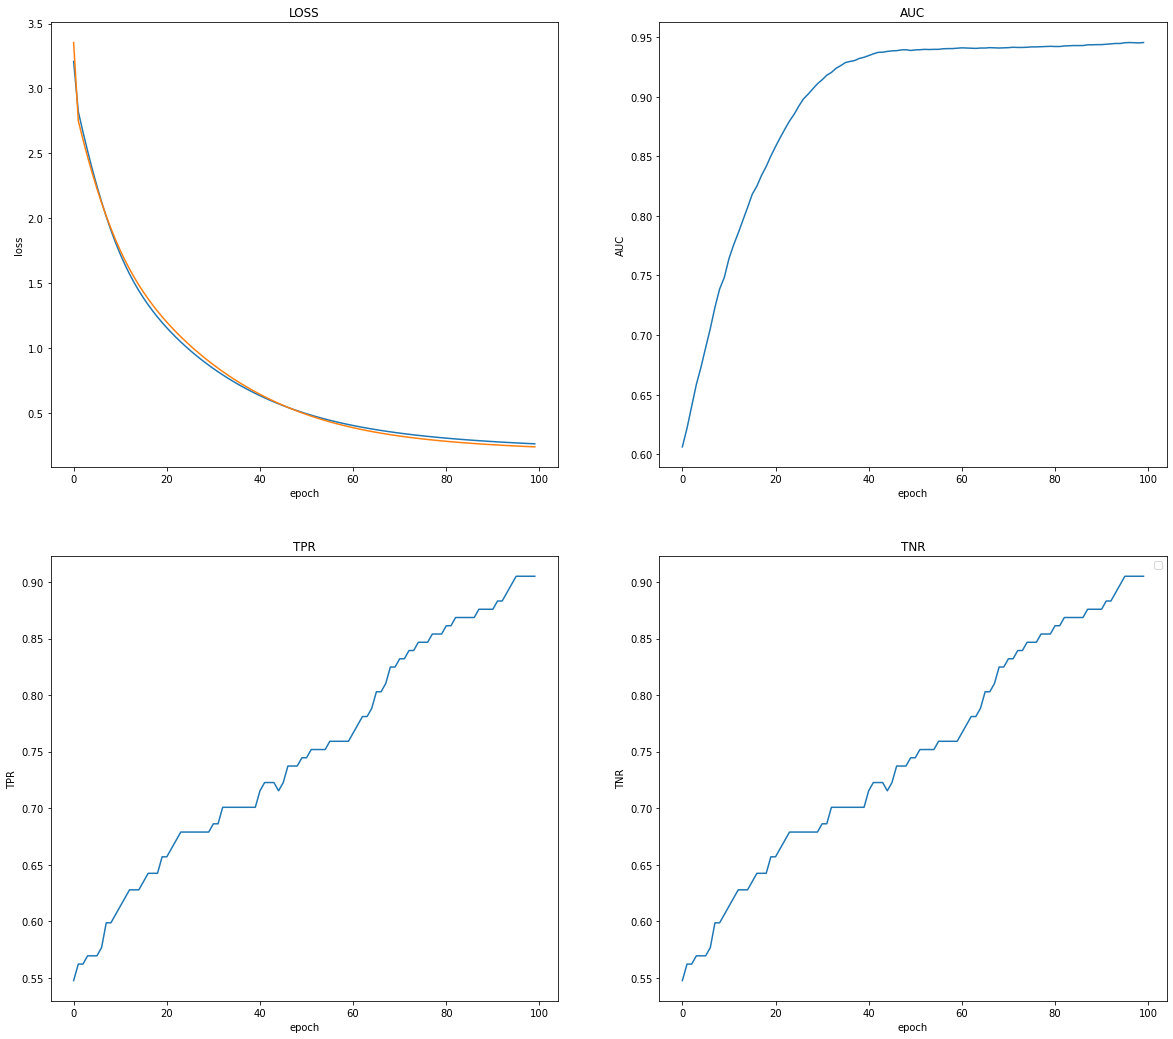

In [488]:
# loss
plt.figure(figsize=(20, 18))
plt.subplot(2, 2, 1)
x = np.arange(0, epoches)
plt.plot(x, losses_train, label='train')
plt.plot(x, losses_test, label='test')
plt.title('LOSS')
plt.xlabel('epoch')
plt.ylabel('loss')


# 计算 auc, 真阳率(true positive rate), 真阴率(true negative rate)
from sklearn.metrics import confusion_matrix, roc_auc_score
label_true = df_test['label'].to_numpy()
aucs, tprs, tnrs = [], [], []
theshold = 0.5

for pred in predictions:
    aucs.append(roc_auc_score(label_true, pred))
    tmp = pred.copy()
    tmp[tmp >= theshold] = 1
    tmp[tmp < theshold] = 0
    tn, fp, fn, tp = confusion_matrix(label_true, tmp).ravel()
    tprs.append(tp/(tp+fn))
    tnrs.append(tn/(tn+fp))

# plt.figure(figsize=(10, 18))
tittle = 'AUC TPR TNR'.split()
x = np.arange(0, epoches)
for index, matric in enumerate([aucs, tprs, tprs]):
    plt.subplot(2, 2, index+2)
    plt.plot(x, matric)
    plt.title(tittle[index])
    plt.xlabel('epoch')
    plt.ylabel(tittle[index])
plt.legend()
plt.show()